# LSTM: Sectionals_v3

Train an LSTM to analyze a horse’s past performance sequence and predict the horse's race pattern that reflects its projected strength today.

### Target is distance_back

✅ This model, unless it proves predictive on a standalone capactity, will be fed into the CatBoost/YetiRank model as a feature.

⸻

🔍 How Accurate is Ranking by Sectional Data Alone?

🔥 The Good:

If your LSTM is trained on well-normalized, consistent historical speed signals: • Relative ordering can be quite meaningful • Especially in smaller fields or when you’re identifying top 3–4 finishers • Even if absolute values are off, ranking is often more robust

❄️ The Limitations: • LSTM alone won’t account for today’s track conditions, surface bias, jockey/trainer changes, distance, class jump/drop • It may favor horses that ran fast recently but are now outclassed or mispositioned

In [1]:
# Setup Environment
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

# Setup Environment
import time
import threading
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import optuna_dashboard
import os
import logging
import copy
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import optuna
from torch.optim.lr_scheduler import OneCycleLR, StepLR
import torch.nn as nn
import numpy as np
import optuna.visualization as viz
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import (to_date, date_format, lpad, concat_ws, collect_list, struct, 
                                   col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql

In [2]:
print(optuna_dashboard.__version__)  # should print 0.18.0

0.18.0


In [4]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [5]:
def gps_sql_queries():
    queries = {
#         "gps_horse": """
#             SELECT g.course_cd, g.race_date,g.race_number,
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, time_stamp, 
#             longitude, latitude, speed, progress, stride_frequency, g.post_time, location,
#             re.axciskey, h.horse_id, re.official_fin, h.horse_name
#             FROM gpspoint g
#             JOIN results_entries re on g.course_cd = re.course_cd
#                 AND g.race_date = re.race_date
#                 AND g.race_number = re.race_number
#                 AND g.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey
#             WHERE speed is not null
#             AND progress is not null
#             AND stride_frequency is not null
#             """,
        "sectionals": """
            SELECT s.course_cd, s.race_date, s.race_number, h.horse_id, 
            REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, 
            s.gate_name, s.gate_numeric, s.length_to_finish, s.sectional_time, s.running_time, 
            s.distance_back, s.distance_ran, s.number_of_strides, s.post_time, re.official_fin
            FROM sectionals s
            JOIN results_entries re on s.course_cd = re.course_cd
                AND s.race_date = re.race_date
                AND s.race_number = re.race_number
                AND s.saddle_cloth_number = re.program_num
            JOIN horse h on re.axciskey = h.axciskey 
            WHERE length_to_finish is not null
            AND sectional_time is not null
            AND running_time is not null
            AND distance_back is not null
            AND distance_ran is not null
            AND distance_ran is not null
            AND number_of_strides is not null
            """
    }
    return queries


In [6]:
queries = gps_sql_queries()
dfs = load_data_from_postgresql(spark, jdbc_url, jdbc_properties, queries, parquet_dir)
        # Suppose we have a dictionary of queries
for name, df in dfs.items():
    logging.info(f"DataFrame '{name}' loaded. Schema:")
    df.printSchema()
    if name == "gps_horse":
        gps_horse_df = df
    elif name == "sectionals":
        sectionals_df = df    
    else:
        logging.error(f"Unknown DataFrame name: {name}")
        continue


root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)



In [7]:

start_time = time.time()
# # gps_horse_df.write.mode("overwrite").parquet(f"{parquet_dir}/gps_horse_df")
sectionals_df.write.mode("overwrite").parquet(f"{parquet_dir}/sectionals_df")
logging.info(f"Data written to Parquet in {time.time() - start_time:.2f} seconds")
    

In [8]:
# gps_horse_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/gps_horse_df")
sectionals_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/sectionals_df")


In [9]:
sectionals_df.count()

5071338

## Create race_id

In [10]:
# Convert race_date to a proper date format
sectionals_df = sectionals_df.withColumn("race_date", to_date(col("race_date")))

# Construct a unique race_id using course_cd, race_date, and race_number
sectionals_df = sectionals_df.withColumn(
    "race_id",
    concat_ws(
        "_",
        col("course_cd"),
        date_format(col("race_date"), "yyyyMMdd"),
        lpad(col("race_number").cast("string"), 2, "0")
    )
)


## Create gate_seq_num Column

### 1) Cast gate_numeric to a Numeric Type

In [11]:
# For example, cast gate_numeric to double:
sectionals_df = sectionals_df.withColumn("gate_numeric", col("gate_numeric").cast("double"))

# Then (re)do your steps with the numeric column

In [12]:

# Step 1: Filter out finish rows to compute max gate_numeric per race
non_finish_df = sectionals_df.filter(F.col("gate_name") != "finish")

# Define a window partitioning by race identifiers
race_window = Window.partitionBy("course_cd", "race_date", "race_number")

# Compute maximum gate_numeric for each race (ignoring finish rows)
max_gate_df = non_finish_df.groupBy("course_cd", "race_date", "race_number") \
    .agg(F.max("gate_numeric").alias("max_gate_numeric"))

# Step 2: Join the maximum gate value back to the original DataFrame
joined_df = sectionals_df.join(max_gate_df, on=["course_cd", "race_date", "race_number"], how="left")

# Step 3: Create the new column 'gate_seq_num'
# If the gate is 'finish', assign max_gate_numeric + 0.5, else keep gate_numeric.
sectionals_df = joined_df.withColumn(
    "gate_seq_num",
    F.when(F.col("gate_name") == "finish", F.col("max_gate_numeric") + F.lit(0.5))
     .otherwise(F.col("gate_numeric"))
)

## Sort

In [13]:
sectionals_df.select("saddle_cloth_number", "gate_name", "gate_seq_num", "running_time") \
  .filter("race_id = 'TGP_20240818_09' AND saddle_cloth_number = 3") \
  .orderBy(F.asc("gate_seq_num")) \
  .show(50, truncate=False)

+-------------------+---------+------------+------------+
|saddle_cloth_number|gate_name|gate_seq_num|running_time|
+-------------------+---------+------------+------------+
|3                  |0.32f    |0.32        |97.868      |
|3                  |0.82f    |0.82        |91.295      |
|3                  |1.32f    |1.32        |84.886      |
|3                  |1.82f    |1.82        |78.442      |
|3                  |2.32f    |2.32        |71.884      |
|3                  |2.82f    |2.82        |65.485      |
|3                  |3.32f    |3.32        |59.242      |
|3                  |3.82f    |3.82        |53.334      |
|3                  |4.32f    |4.32        |47.578      |
|3                  |4.82f    |4.82        |41.847      |
|3                  |5.32f    |5.32        |36.056      |
|3                  |5.82f    |5.82        |30.109      |
|3                  |6.32f    |6.32        |24.409      |
|3                  |6.82f    |6.82        |18.789      |
|3            

## Extract the Final Distance for Each Horse

In [14]:

# A) Filter just the finish rows
finish_df = sectionals_df.filter(F.col("gate_name") == "finish")

# B) Select the final distance for that horse
#    We'll rename it to "final_dist" to avoid conflict
finish_dist_df = finish_df.select(
    "race_id",
    "horse_id",
    F.col("distance_back").alias("final_dist")
)

## Join This Final Distance Back to All Rows

In [15]:
# Join on (race_id, horse_id) so every row for that horse
# gets the final distance, if it exists.
with_final_dist = sectionals_df.join(
    finish_dist_df,
    on=["race_id", "horse_id"],
    how="left"
)

## Filter Out the Finish Row

In [16]:
partial_only_df = with_final_dist.filter(F.col("gate_name") != "finish")

## Rename final_dist to target

In [17]:
partial_only_df = partial_only_df.withColumnRenamed("final_dist", "target")

In [18]:
sectionals_df = partial_only_df

sectionals_df.printSchema()

root
 |-- race_id: string (nullable = false)
 |-- horse_id: integer (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- target: double (nullable = true)



In [19]:
from pyspark.sql import functions as F

filtered_sectionals_df = (
    sectionals_df
      .filter(
          (F.col("race_id")        == "TGP_20240818_09") &   # ← first condition
          (F.col("distance_back")  == 0.0)                  # ← second condition
      )
      .select(
          "course_cd", "race_date", "race_number",
          "saddle_cloth_number", "distance_back", "gate_name", "target"
      )
      .distinct()
)

filtered_sectionals_df.show()

+---------+----------+-----------+-------------------+-------------+---------+------+
|course_cd| race_date|race_number|saddle_cloth_number|distance_back|gate_name|target|
+---------+----------+-----------+-------------------+-------------+---------+------+
|      TGP|2024-08-18|          9|                  6|          0.0|    6.32f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    7.82f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    0.32f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    3.82f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    2.82f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    4.32f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    7.32f|   0.0|
|      TGP|2024-08-18|          9|                  6|          0.0|    5.82f|   0.0|
|      TGP|2024-08-18|          9|                  6|

# Compute Sequence Lenghts

### Filter Rows with >=1 and <=38 Sequences

In [20]:

# Step 1: Compute sequence lengths per horse per race
df_seq_len = sectionals_df.groupBy("race_id", "horse_id").agg(F.count("*").alias("seq_length"))

# Step 2: Filter sequences with length between 1 and 38
filtered_df = df_seq_len.filter((F.col("seq_length") >= 1) & (F.col("seq_length") <= 38))

# Step 3: Join the filtered sequence lengths back with the original data
sectionals_df = sectionals_df.join(filtered_df, on=["race_id", "horse_id"], how="inner")

### Plot Sequence Lengths

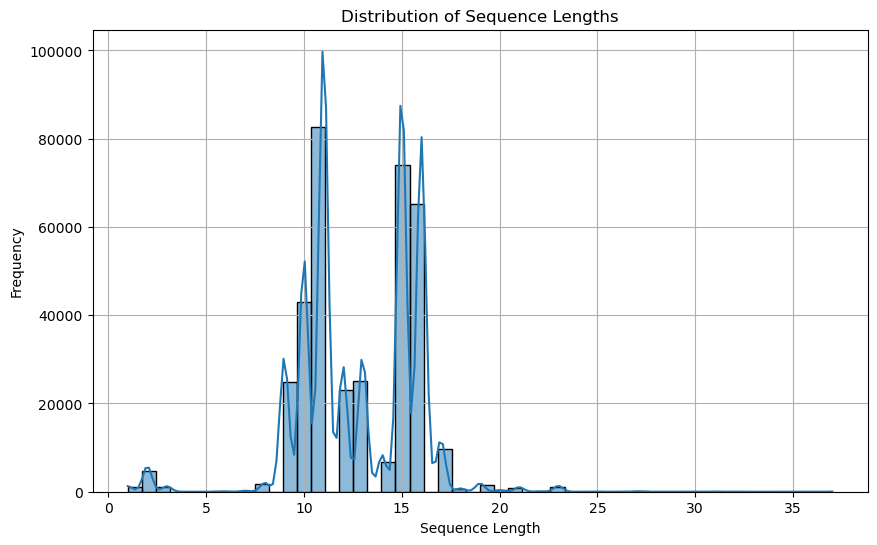

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_seq_len is a DataFrame with a 'seq_length' column
# If df_seq_len is a PySpark DataFrame, convert it to Pandas
df_seq_len_pd = df_seq_len.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_seq_len_pd['seq_length'], bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Padding Sequences to a Fixed Length

###  Step 1: Convert to Sequence Format

In [22]:
sectionals_df.printSchema()

root
 |-- race_id: string (nullable = false)
 |-- horse_id: integer (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- target: double (nullable = true)
 |-- seq_length: long (nullable = false)



## Create segment_ordinal

In [23]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

w = Window.partitionBy("race_id", "horse_id").orderBy(F.asc("gate_seq_num"))

sectionals_df = sectionals_df.withColumn(
    "segment_ordinal",
    F.row_number().over(w)   # 1-based index for each call in ascending order
)

## Make Sequences

In [24]:
features = [
    "length_to_finish",
    "sectional_time",
    "running_time",
    "distance_back",
    "distance_ran",
    "number_of_strides"
]

In [25]:
from pyspark.sql.functions import struct, collect_list

df_features = sectionals_df.select(
    "race_id",
    "horse_id",
    "segment_ordinal",
    F.struct(*[F.col(f) for f in features]).alias("feature_struct")
)

# Window to collect all rows (time steps) for each (race_id, horse_id).
collect_w = Window.partitionBy("race_id", "horse_id").orderBy("segment_ordinal") \
                  .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_features = df_features.withColumn(
    "sequence",
    collect_list("feature_struct").over(collect_w)
)

# Now each row for that horse has a "sequence", but repeated for each time step.
# We only want the final row for each horse, i.e. the row with max(segment_ordinal).
df_features = df_features.withColumn(
    "rn",
    F.row_number().over(
        Window.partitionBy("race_id", "horse_id").orderBy(F.desc("segment_ordinal"))
    )
)

# Keep only rn == 1 (the row with the largest segment_ordinal => entire sequence):
df_features = df_features.filter(F.col("rn") == 1)

# Now df_features has columns: [race_id, horse_id, sequence], one row per horse.
df_features = df_features.select("race_id", "horse_id", "sequence")

In [26]:
df_features = df_features.join(
    sectionals_df
        .select("race_id", "horse_id", "target")
        .dropDuplicates(["race_id", "horse_id"]), 
    on=["race_id", "horse_id"],
    how="left"
)

In [27]:
from pyspark.sql.types import ArrayType, StructType, StructField, FloatType

# We must define the schema for the array of structs that we store in "sequence".
# If you have 6 float features, define them accordingly. For example:
feature_struct_schema = StructType([
    StructField("length_to_finish", FloatType(), True),
    StructField("sectional_time", FloatType(), True),
    StructField("running_time", FloatType(), True),
    StructField("distance_back", FloatType(), True),
    StructField("distance_ran", FloatType(), True),
    StructField("number_of_strides", FloatType(), True)
])

target_len = 38

# Python function to pad/truncate a list of structs:
def pad_sequence(seq, max_len=target_len):
    """Truncates if len(seq)>max_len, else pads with zero-like structs."""
    if seq is None:
        return []
    
    seq = list(seq)  # ensure it's mutable

    # 1) Truncate if too long
    if len(seq) > max_len:
        seq = seq[:max_len]

    # 2) Pad if too short
    while len(seq) < max_len:
        seq.append({
            "length_to_finish": 0.0,
            "sectional_time": 0.0,
            "running_time": 0.0,
            "distance_back": 0.0,
            "distance_ran": 0.0,
            "number_of_strides": 0.0
        })
    return seq

pad_sequence_udf = F.udf(lambda seq: pad_sequence(seq, target_len), 
                         ArrayType(feature_struct_schema))

df_features = df_features.withColumn(
    "padded_sequence", 
    pad_sequence_udf("sequence")
)

In [28]:
df_features.columns

['race_id', 'horse_id', 'sequence', 'target', 'padded_sequence']

### Convert to Pandas

In [29]:
all_pd = df_features.toPandas()

# Sort by race_date to maintain temporal order
all_pd = all_pd.sort_values("race_id").reset_index(drop=True)

### Drop NaN target

In [30]:
# Number of rows before
old_count = len(all_pd)

# Drop rows where "target" is NaN
all_pd = all_pd.dropna(subset=["target"])

# Number of rows after
new_count = len(all_pd)

print(f"Rows before drop: {old_count}, after drop: {new_count}")
print(f"Rows dropped: {old_count - new_count}")

Rows before drop: 367657, after drop: 367475
Rows dropped: 182


# Split & Normalize

## Split by Entire Race 

In [31]:
import numpy as np
import pandas as pd

def prepare_data_3way_split_by_race(
    df,
    race_date_col=None,
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    target_len=38
):
    """
    Splits the entire dataset into (train, val, test) by race_id so that
    all horses in a race go to the same split. Then, for each subset,
    we build X arrays of shape (num_samples, target_len, 6) [or #features],
    y arrays of shape (num_samples,), and we keep an array of race_ids as well.

    Returns:
      (X_train, y_train, race_ids_train,
       X_val,   y_val,   race_ids_val,
       X_test,  y_test,  race_ids_test)
    """

    # -----------------------------
    # (A) Sort the race_ids
    # -----------------------------
    #  If you have a race_date column, use it to sort the races in chronological order
    if race_date_col and race_date_col in df.columns:
        # Make sure race_date_col is a date or something sortable
        # Then collect unique (race_id, race_date), sort by race_date
        race_date_map = (
            df[[race_date_col, "race_id"]]
            .drop_duplicates(subset=["race_id"])
            .sort_values(by=race_date_col)
        )
        race_ids_sorted = race_date_map["race_id"].tolist()
    else:
        # If no date, lexicographically sort the unique race_ids
        race_ids_sorted = sorted(df["race_id"].unique())

    n_races = len(race_ids_sorted)
    n_train = int(train_frac * n_races)
    n_val   = int(val_frac   * n_races)
    # remainder goes to test
    n_test  = n_races - (n_train + n_val)

    # slice them
    train_races = race_ids_sorted[:n_train]
    val_races   = race_ids_sorted[n_train : n_train + n_val]
    test_races  = race_ids_sorted[n_train + n_val : ]

    # -----------------------------
    # (B) Filter the main df
    # -----------------------------
    df_train = df[df["race_id"].isin(train_races)].copy()
    df_val   = df[df["race_id"].isin(val_races)].copy()
    df_test  = df[df["race_id"].isin(test_races)].copy()

    # Optionally ensure no duplicates
    df_train = df_train.drop_duplicates(subset=["race_id", "horse_id"])
    df_val   = df_val.drop_duplicates(subset=["race_id", "horse_id"])
    df_test  = df_test.drop_duplicates(subset=["race_id", "horse_id"])

    # -----------------------------
    # (C) Build arrays (X, y, race_ids) for each subset
    # -----------------------------

    def build_lstm_arrays(sub_df, target_len):
        X_list = []
        y_list = []
        rid_list = []
        hid_list = []
        
        for _, row in sub_df.iterrows():
            # This is already a list of exactly 'target_len' dicts
            seq_data = row["padded_sequence"]  

            # Convert each dict in seq_data into a numeric [6]-list
            numeric_seq = []
            for d in seq_data:
                numeric_seq.append([
                    d["length_to_finish"],
                    d["sectional_time"],
                    d["running_time"],
                    d["distance_back"],
                    d["distance_ran"],
                    d["number_of_strides"]
                ])

            X_list.append(numeric_seq)
            y_list.append(row["target"])   # or row["target"], if that’s your label
            rid_list.append(row["race_id"])
            hid_list.append(row["horse_id"])
            
        X_array = np.array(X_list, dtype=np.float32)
        y_array = np.array(y_list, dtype=np.float32)
        r_array = np.array(rid_list)
        h_array = np.array(hid_list, dtype=np.int64)
        
        return X_array, y_array, r_array, h_array

    # do it for each
    X_train, y_train, raceids_train, horseids_train = build_lstm_arrays(df_train, target_len)
    X_val,   y_val,   raceids_val,   horseids_val   = build_lstm_arrays(df_val,   target_len)
    X_test,  y_test,  raceids_test,  horseids_test  = build_lstm_arrays(df_test,  target_len)

    return (
        X_train, y_train, raceids_train, horseids_train,
        X_val,   y_val,   raceids_val,   horseids_val,
        X_test,  y_test,  raceids_test,  horseids_test
    )

## Define Helper Functions

In [32]:
class SingleHorseDataset(Dataset):
    def __init__(self, X_array, y_array):
        """
        X_array: shape (N, seq_len, num_features)
        y_array: shape (N,)
        """
        self.X_array = X_array
        self.y_array = y_array

    def __len__(self):
        return len(self.X_array)

    def __getitem__(self, idx):
        X = self.X_array[idx]  # (seq_len, num_features)
        y = self.y_array[idx]  # scalar
        # Convert to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        return X_tensor, y_tensor


In [33]:
def prepare_SingleHorse_data(
    X_train, y_train, race_ids_train,
    X_val,   y_val,   race_ids_val,
    X_test,  y_test,  race_ids_test,
):
    """
    1) Caps outliers (1st/99th percentile).
    2) MinMax-scales features.
    3) Builds three SingleHorseDatasets & DataLoaders (train, val, test).
    """

    def cap_outliers(data, lower=1, upper=99):
        lo = np.percentile(data, lower, axis=0)
        hi = np.percentile(data, upper, axis=0)
        return np.clip(data, lo, hi)
    
    # --- Training set ---
    num_train, seq_len, num_features = X_train.shape
    X_train_flat = X_train.reshape(-1, num_features)
    X_train_cap = cap_outliers(X_train_flat)
    scaler_X = MinMaxScaler()
    X_train_scaled_flat = scaler_X.fit_transform(X_train_cap)
    X_train_scaled = X_train_scaled_flat.reshape(num_train, seq_len, num_features)
    
    # --- Validation set ---
    num_val, seq_len_val, num_features_val = X_val.shape
    X_val_flat = X_val.reshape(-1, num_features_val)
    X_val_cap = cap_outliers(X_val_flat)
    X_val_scaled_flat = scaler_X.transform(X_val_cap)
    X_val_scaled = X_val_scaled_flat.reshape(num_val, seq_len_val, num_features_val)
    
    # --- Test set ---
    num_test, seq_len_test, num_features_test = X_test.shape
    X_test_flat = X_test.reshape(-1, num_features_test)
    X_test_cap = cap_outliers(X_test_flat)
    X_test_scaled_flat = scaler_X.transform(X_test_cap)
    X_test_scaled = X_test_scaled_flat.reshape(num_test, seq_len_test, num_features_test)
    
    ####################################
    # 1) CAP + SCALE FOR Y_TRAIN
    ####################################
    y_train_unscaled = y_train
    # Reshape to 2D so scaler can work on columns
    y_train_2d = y_train.reshape(-1, 1)

    # Cap outliers
    y_train_cap = cap_outliers(y_train_2d)

    # Fit a separate scaler for the labels
    scaler_y = MinMaxScaler()
    y_train_scaled_2d = scaler_y.fit_transform(y_train_cap)

    # Flatten back to 1D
    y_train_scaled = y_train_scaled_2d.flatten()

    ####################################
    # 2) CAP + SCALE FOR Y_VAL
    ####################################
    y_val_2d = y_val.reshape(-1, 1)
    y_val_cap = cap_outliers(y_val_2d)
    y_val_scaled_2d = scaler_y.transform(y_val_cap)
    y_val_scaled = y_val_scaled_2d.flatten()

    ####################################
    # 3) CAP + SCALE FOR Y_TEST
    ####################################
    y_test_2d = y_test.reshape(-1, 1)
    y_test_cap = cap_outliers(y_test_2d)
    y_test_scaled_2d = scaler_y.transform(y_test_cap)
    y_test_scaled = y_test_scaled_2d.flatten()
    
    ####################################
    # 4) Save Scalers
    ####################################
    save_dir="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionals"
    try:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(scaler_X, os.path.join(save_dir, "scaler_X.pkl"))
        joblib.dump(scaler_y, os.path.join(save_dir, "scaler_y.pkl"))
        print(f"Scalers saved to {save_dir!r}")
    except Exception as e:
        print(f"Failed to save scalers: {e!r}")

    # Build the SingleHorseDatasets
    train_dataset = SingleHorseDataset(X_train_scaled, y_train_scaled)
    val_dataset   = SingleHorseDataset(X_val_scaled,   y_val_scaled)
    test_dataset  = SingleHorseDataset(X_test_scaled,  y_test_scaled)

    # Build DataLoaders (you can pick any batch_size > 1)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

    return (
        X_train_scaled, y_train_scaled, y_train_unscaled, scaler_X, scaler_y,
        X_val_scaled,   y_val_scaled,
        X_test_scaled,  y_test_scaled,
        scaler_X,       scaler_y,  
        train_dataset,  val_dataset,     test_dataset,
        train_loader,   val_loader,     test_loader
    )

In [34]:
(X_train, y_train, raceids_train, horseids_train,
 X_val,   y_val,   raceids_val,   horseids_val,
 X_test,  y_test,  raceids_test,  horseids_test
)= prepare_data_3way_split_by_race(
    df=all_pd, 
    race_date_col="race_date",  # or None if you want lexicographic
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    target_len=38
)


In [35]:
(
    X_train_scaled, y_train_scaled, y_train_unscaled, scaler_x, scaler_y,
    X_val_scaled,   y_val_scaled,
    X_test_scaled,  y_test_scaled,
    scaler_X, scaler_y,
    train_dataset, val_dataset, test_dataset,
    train_loader, val_loader, test_loader
) = prepare_SingleHorse_data(
    X_train, y_train, raceids_train,
    X_val,   y_val,   raceids_val,
    X_test,  y_test,  raceids_test
)

print("Train loader has", len(train_loader), "batches.")
print("Val loader has", len(val_loader), "batches.")
print("Test loader has", len(test_loader), "batches.")

Scalers saved to '/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionals'
Train loader has 15646 batches.
Val loader has 3657 batches.
Test loader has 3665 batches.


# 🧠 Basic LSTM Model for Sequence Classification

In [36]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name 0:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 2
Device name 0: NVIDIA RTX A6000


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train a Simple LSTM Regression Model

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HorseTimeSeriesLSTM(nn.Module):
    def __init__(
        self,
        input_size: int = 6,
        hidden_size: int = 64,
        embedding_size: int = 16,
        dropout: float = 0.0,
        num_layers: int = 1       # ← new parameter with default
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,  # ← pass it here
            batch_first=True
        )
        self.dropout   = nn.Dropout(dropout)
        self.head      = nn.Linear(hidden_size, 1)
        self.projection = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        Returns:
          pred => (batch_size,) numeric regression output
          embed => (batch_size, embedding_size)
        """
        out, (h_n, c_n) = self.lstm(x)
        last_hidden    = out[:, -1, :]
        last_hidden    = self.dropout(last_hidden)
        pred           = self.head(last_hidden).squeeze(1)
        embed          = self.projection(last_hidden)
        return pred, embed

### 🧪 Mini Training Loop

In [106]:
from tqdm.notebook import tqdm
###############################################################################
# Training Loop for One Epoch
###############################################################################
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in tqdm(loader, desc="Training", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        pred, embed = model(X_batch)
        loss = nn.functional.mse_loss(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

In [107]:
###############################################################################
# Evaluation Loop
###############################################################################
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred, embed = model(X_batch)
            loss = nn.functional.mse_loss(pred, y_batch)

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

In [108]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device 0:", torch.cuda.get_device_name(0))
if torch.cuda.device_count() > 1:
    print("Device 1:", torch.cuda.get_device_name(1))

CUDA available: True
CUDA device count: 2
Device 0: NVIDIA RTX A6000
Device 1: NVIDIA RTX A6000


In [113]:
import copy
import optuna
import torch
from torch.utils.data import DataLoader


def objective(trial):
    import torch.optim as optim

    # If you want to pick a specific GPU, or see how many you have
    gpu_count = torch.cuda.device_count()
    print("GPU Count:", gpu_count)
    device = torch.device("cuda" if gpu_count > 0 else "cpu")

    # 1) Hyperparams from Optuna
    lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)  # e.g. between 5e-4 and 5e-3
    step_size = trial.suggest_int("lr_step", 3, 8)      # every k epochs
    gamma     = trial.suggest_float("lr_gamma", 0.1, 0.9)
    # ▾ inside objective(trial) ─ after you sample lr, hidden_size … ▾
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.47, 0.9)
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # 2) Build the single-horse LSTM
    model = HorseTimeSeriesLSTM(
        input_size=6,
        hidden_size=hidden_size,
        embedding_size=16,  # fixed
        dropout=dropout,
        num_layers=num_layers
    )

    # Optionally wrap in DataParallel if >1 GPU
    # Note: This requires batch_size > 1 if we want to see a speedup across GPUs.
    if gpu_count > 1:
        model = nn.DataParallel(model)

    # Move model to device
    model.to(device)

    # 3) Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # new: Step-LR scheduler
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=step_size, gamma=gamma
    )

    # 4) DataLoaders (single-horse datasets)
    #    Make sure these have batch_size > 1 if you want multi-GPU usage to help.
    #    For example, batch_size=16 or 32.
    pin = device.type == "cuda"
    batch_size = 1024

    train_loader = DataLoader(train_dataset, batch_size,
                              shuffle=True,  num_workers=32,
                              pin_memory=pin)
    val_loader   = DataLoader(val_dataset,   batch_size,
                              shuffle=False, num_workers=32,
                              pin_memory=pin)

    
    # 5) Early Stopping Setup
    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    patience = 10
    epochs_without_improvement = 0
    num_epochs = 50

    # 6) Main Training Loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss   = evaluate(model, val_loader, device)

        print(f"[Epoch {epoch+1}/{num_epochs}] train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Optuna pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        if not trial.should_prune(): scheduler.step()

    # 7) Load best model state and return best_val_loss
    model.load_state_dict(best_model_state)
    return best_val_loss

In [114]:
import inspect, threading, optuna_dashboard as od

def run_optuna(n_trials: int = 150):

    # ── 1. create / load the study ────────────────────────────────────
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=20, n_warmup_steps=3, interval_steps=1
    )
    study = optuna.create_study(
        study_name="horse_race_study_v1",
        storage="sqlite:///optuna_sec_lstm.db",
        direction="minimize",
        pruner=pruner,
        load_if_exists=True
    )

#     # ── 2. start dashboard in background (non-blocking) ──────────────
#     def _dashboard():
#         kwargs = dict(host="127.0.0.1", port=8089)          # always accepted
#         sig = inspect.signature(od.run_server).parameters   # look at runtime
#         if "open_browser" in sig:
#             kwargs["open_browser"] = True                   # 0.17+ has it
#         if "readonly" in sig:                               # 0.18+
#             kwargs["readonly"] = False
#         # add reload only if the version supports it
#         if "reload" in sig:
#             kwargs["reload"] = False

#         od.run_server("sqlite:///optuna_sec_lstm.db", **kwargs)

#     threading.Thread(target=_dashboard, daemon=True).start()
#     print("🔗 Optuna dashboard at http://127.0.0.1:8089")    # ── 3. run optimisation ──────────────────────────────────────────
    
#     study.optimize(objective, n_trials=n_trials)

    # ── 4. report best result ────────────────────────────────────────
    best = study.best_trial
    print("\nBest trial")
    print(f"  • val_loss = {best.value:.5f}")
    for k, v in best.params.items():
        print(f"  • {k:12}= {v}")

    return study

In [115]:
# !pip install -U "optuna-dashboard>=0.18.0"
# !python -c "import optuna_dashboard, sys; print(optuna_dashboard.__version__, sys.executable)"

In [116]:
# Run Optuna tuning
study = run_optuna(n_trials=150)

[I 2025-05-06 00:33:08,791] Using an existing study with name 'horse_race_study_v1' instead of creating a new one.
Bottle v0.13.2 server starting up (using WSGIRefServer())...
Listening on http://127.0.0.1:8089/
Hit Ctrl-C to quit.

Exception in thread Thread-936021 (_dashboard):
Traceback (most recent call last):
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_3192651/2267224988.py", line 29, in _dashboard
  File "/home/exx/anaconda3/envs/mamba_env/envs/tf_310/lib/python3.10/site-packages/optuna_dashboard/_app.py", line 661, in run_server
    run(app, host=host, port=port)


🔗 Optuna dashboard at http://127.0.0.1:8089
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:33:51,086] Trial 242 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0326, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0404, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:34:27,446] Trial 243 pruned. 


[Epoch 4/50] train_loss=0.0402, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:35:09,591] Trial 244 pruned. 


[Epoch 4/50] train_loss=0.0405, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0428, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:35:51,731] Trial 245 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:36:33,763] Trial 246 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0425, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:37:15,966] Trial 247 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0451, val_loss=0.0430


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0423, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0420, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:37:58,098] Trial 248 pruned. 


[Epoch 4/50] train_loss=0.0418, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0494, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0428, val_loss=0.0400


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0258, val_loss=0.0125


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:38:40,399] Trial 249 pruned. 


[Epoch 4/50] train_loss=0.0120, val_loss=0.0070
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0414, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:39:25,324] Trial 250 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0416, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:40:05,467] Trial 251 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0429, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0361, val_loss=0.0438


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:40:47,830] Trial 252 pruned. 


[Epoch 4/50] train_loss=0.0405, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0405, val_loss=0.0249


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0087, val_loss=0.0041


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0052, val_loss=0.0034


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0046, val_loss=0.0032


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0044, val_loss=0.0032


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0043, val_loss=0.0028


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0043, val_loss=0.0027


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0042, val_loss=0.0031


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0039, val_loss=0.0034


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0039, val_loss=0.0028


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0039, val_loss=0.0027


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0039, val_loss=0.0025


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:42:48,225] Trial 253 pruned. 


[Epoch 13/50] train_loss=0.0038, val_loss=0.0027
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0425, val_loss=0.0432


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0397, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:43:28,278] Trial 254 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0417, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:44:10,255] Trial 255 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0417, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0398, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:44:52,532] Trial 256 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:45:34,824] Trial 257 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0436, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0417, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0404, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:46:17,059] Trial 258 pruned. 


[Epoch 4/50] train_loss=0.0409, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0436, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:46:59,292] Trial 259 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0417, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:47:38,538] Trial 260 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0459, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:48:20,880] Trial 261 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0419, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:49:03,342] Trial 262 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0448, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0418, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:49:39,258] Trial 263 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0446, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0421, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0414, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:50:19,280] Trial 264 pruned. 


[Epoch 4/50] train_loss=0.0397, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:51:04,152] Trial 265 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0429, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0405, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:51:44,013] Trial 266 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0420, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:52:26,127] Trial 267 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:53:06,280] Trial 268 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0423, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:53:48,802] Trial 269 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0419, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:54:30,950] Trial 270 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:55:13,499] Trial 271 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:55:53,504] Trial 272 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0419, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:56:35,798] Trial 273 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:57:18,206] Trial 274 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0413, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:58:00,246] Trial 275 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0417, val_loss=0.0327


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0399, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:58:42,320] Trial 276 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0428, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:59:22,385] Trial 277 pruned. 


[Epoch 4/50] train_loss=0.0410, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 00:59:58,512] Trial 278 pruned. 


[Epoch 4/50] train_loss=0.0399, val_loss=0.0269
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:00:40,774] Trial 279 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0416, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:01:16,476] Trial 280 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0416, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:01:58,417] Trial 281 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:02:40,758] Trial 282 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0561, val_loss=0.0440


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0449, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0220, val_loss=0.0101


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:03:17,500] Trial 283 pruned. 


[Epoch 4/50] train_loss=0.0127, val_loss=0.0056
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:03:59,946] Trial 284 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0431, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0411, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:04:42,126] Trial 285 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0421
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:05:22,163] Trial 286 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0356, val_loss=0.0198


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:06:04,312] Trial 287 pruned. 


[Epoch 4/50] train_loss=0.0138, val_loss=0.0083
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0413, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:06:46,641] Trial 288 pruned. 


[Epoch 4/50] train_loss=0.0373, val_loss=0.0078
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0440, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0417, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:07:26,867] Trial 289 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0425, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0412, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0384, val_loss=0.0229


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:08:09,140] Trial 290 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0422


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:08:51,402] Trial 291 pruned. 


[Epoch 4/50] train_loss=0.0318, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:09:31,779] Trial 292 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0422, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:10:13,868] Trial 293 pruned. 


[Epoch 4/50] train_loss=0.0392, val_loss=0.0246
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0421


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:10:56,138] Trial 294 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0549, val_loss=0.0453


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0436, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0428, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:11:38,463] Trial 295 pruned. 


[Epoch 4/50] train_loss=0.0422, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0398, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:12:16,407] Trial 296 pruned. 


[Epoch 4/50] train_loss=0.0373, val_loss=0.0422
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0431, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0415, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0392, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:12:58,630] Trial 297 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0420, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:13:35,597] Trial 298 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:14:15,494] Trial 299 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0434, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0418, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0400, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:14:55,574] Trial 300 pruned. 


[Epoch 4/50] train_loss=0.0418, val_loss=0.0489
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0301, val_loss=0.0193


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0186, val_loss=0.0192


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:15:37,672] Trial 301 pruned. 


[Epoch 4/50] train_loss=0.0186, val_loss=0.0207
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:16:14,756] Trial 302 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0532, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:16:56,909] Trial 303 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0414, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:17:39,136] Trial 304 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:18:21,405] Trial 305 pruned. 


[Epoch 4/50] train_loss=0.0398, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0443, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0417, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:19:01,503] Trial 306 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0507, val_loss=0.0429


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0418, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0382, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:19:38,401] Trial 307 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0417, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0382, val_loss=0.0227


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:20:20,844] Trial 308 pruned. 


[Epoch 4/50] train_loss=0.0400, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0438, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:21:00,955] Trial 309 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0401
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0419, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:21:45,955] Trial 310 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0424, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:22:26,346] Trial 311 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0425, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:23:08,820] Trial 312 pruned. 


[Epoch 4/50] train_loss=0.0327, val_loss=0.0215
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0456, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0356, val_loss=0.0213


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0143, val_loss=0.0088


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:23:47,071] Trial 313 pruned. 


[Epoch 4/50] train_loss=0.0097, val_loss=0.0063
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0409, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:24:29,650] Trial 314 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0430


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:25:09,799] Trial 315 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0428


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:25:54,849] Trial 316 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0448, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0403, val_loss=0.0347


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0272, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:26:35,370] Trial 317 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:27:15,599] Trial 318 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0420, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:27:58,076] Trial 319 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0413, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:28:34,230] Trial 320 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:29:19,384] Trial 321 pruned. 


[Epoch 4/50] train_loss=0.0264, val_loss=0.0082
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0428, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:29:59,789] Trial 322 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0420, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:30:42,360] Trial 323 pruned. 


[Epoch 4/50] train_loss=0.0373, val_loss=0.0235
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0428, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:31:24,975] Trial 324 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0431, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:32:05,083] Trial 325 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0432, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:32:42,285] Trial 326 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0414
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0416, val_loss=0.0429


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0413, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:33:24,576] Trial 327 pruned. 


[Epoch 4/50] train_loss=0.0411, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0429, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:34:07,311] Trial 328 pruned. 


[Epoch 4/50] train_loss=0.0413, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0430, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0387, val_loss=0.0250


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0403, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:34:47,701] Trial 329 pruned. 


[Epoch 4/50] train_loss=0.0410, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:35:30,178] Trial 330 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0517, val_loss=0.0428


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0430, val_loss=0.0364


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0130, val_loss=0.0047


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:36:07,465] Trial 331 pruned. 


[Epoch 4/50] train_loss=0.0080, val_loss=0.0050
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0417, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0402, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:36:47,785] Trial 332 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:37:32,850] Trial 333 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:38:13,000] Trial 334 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0476, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0387, val_loss=0.0257


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0217, val_loss=0.0160


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:38:55,630] Trial 335 pruned. 


[Epoch 4/50] train_loss=0.0152, val_loss=0.0096
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0432, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0416, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0413, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:39:33,644] Trial 336 pruned. 


[Epoch 4/50] train_loss=0.0349, val_loss=0.0177
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0400, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:40:13,970] Trial 337 pruned. 


[Epoch 4/50] train_loss=0.0404, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0421


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:40:56,529] Trial 338 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0416, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0413, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:41:38,701] Trial 339 pruned. 


[Epoch 4/50] train_loss=0.0411, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0424, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0412, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0361, val_loss=0.0297


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:42:21,240] Trial 340 pruned. 


[Epoch 4/50] train_loss=0.0271, val_loss=0.0264
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0404, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:43:03,442] Trial 341 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0412, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0393, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:43:43,514] Trial 342 pruned. 


[Epoch 4/50] train_loss=0.0375, val_loss=0.0184
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0437, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:44:19,942] Trial 343 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:45:05,020] Trial 344 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:45:45,192] Trial 345 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0405, val_loss=0.0458


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:46:25,687] Trial 346 pruned. 


[Epoch 4/50] train_loss=0.0329, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:47:08,238] Trial 347 pruned. 


[Epoch 4/50] train_loss=0.0482, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0422, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:47:46,574] Trial 348 pruned. 


[Epoch 4/50] train_loss=0.0409, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0427, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0414, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:48:31,487] Trial 349 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0426, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0428


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0402, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:49:13,818] Trial 350 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0241


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0394, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:49:50,233] Trial 351 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:50:32,543] Trial 352 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0426, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0412, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:51:12,730] Trial 353 pruned. 


[Epoch 4/50] train_loss=0.0410, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0437, val_loss=0.0429


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0417, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:51:55,002] Trial 354 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0404, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:52:31,332] Trial 355 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:53:16,177] Trial 356 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0428


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:53:58,578] Trial 357 pruned. 


[Epoch 4/50] train_loss=0.0155, val_loss=0.0065
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0426, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:54:38,667] Trial 358 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0433, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0415, val_loss=0.0428


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0411, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:55:16,734] Trial 359 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:55:59,135] Trial 360 pruned. 


[Epoch 4/50] train_loss=0.0408, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0361, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:56:39,366] Trial 361 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0412, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:57:24,737] Trial 362 pruned. 


[Epoch 4/50] train_loss=0.0409, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0413, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0388


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0374, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:58:05,058] Trial 363 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0428, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:58:47,457] Trial 364 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0401, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 01:59:29,747] Trial 365 pruned. 


[Epoch 4/50] train_loss=0.0410, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0433, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:00:09,904] Trial 366 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0416, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:00:54,972] Trial 367 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:01:35,175] Trial 368 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0434, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0416, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0410, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:02:17,496] Trial 369 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:02:57,685] Trial 370 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0423
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0442, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0421, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0417, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:03:40,145] Trial 371 pruned. 


[Epoch 4/50] train_loss=0.0415, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:04:17,103] Trial 372 pruned. 


[Epoch 4/50] train_loss=0.0409, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0402, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:05:18,344] Trial 373 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0459, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0431, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0426, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:07:11,067] Trial 374 pruned. 


[Epoch 4/50] train_loss=0.0423, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0500, val_loss=0.0430


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0428, val_loss=0.0428


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0381, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:07:48,829] Trial 375 pruned. 


[Epoch 4/50] train_loss=0.0403, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0423, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0413, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:08:29,493] Trial 376 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:09:11,941] Trial 377 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:09:54,220] Trial 378 pruned. 


[Epoch 4/50] train_loss=0.0411, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0437, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0417, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0354, val_loss=0.0224


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:10:36,828] Trial 379 pruned. 


[Epoch 4/50] train_loss=0.0348, val_loss=0.0225
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0437, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0317, val_loss=0.0069


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0074, val_loss=0.0045


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:11:14,232] Trial 380 pruned. 


[Epoch 4/50] train_loss=0.0063, val_loss=0.0049
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0420, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0409, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0407, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:11:54,535] Trial 381 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0411, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:12:37,254] Trial 382 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0423, val_loss=0.0423


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:13:13,570] Trial 383 pruned. 


[Epoch 4/50] train_loss=0.0407, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0424, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0412, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0373, val_loss=0.0230


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:13:54,032] Trial 384 pruned. 


[Epoch 4/50] train_loss=0.0317, val_loss=0.0097
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0283, val_loss=0.0054


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0069, val_loss=0.0042


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0052, val_loss=0.0052


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:14:39,009] Trial 385 pruned. 


[Epoch 4/50] train_loss=0.0048, val_loss=0.0036
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0440, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0419, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0416, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:15:19,467] Trial 386 pruned. 


[Epoch 4/50] train_loss=0.0370, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0418, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0411, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0409, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:15:57,642] Trial 387 pruned. 


[Epoch 4/50] train_loss=0.0380, val_loss=0.0237
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0426, val_loss=0.0425


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0411, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:16:40,224] Trial 388 pruned. 


[Epoch 4/50] train_loss=0.0394, val_loss=0.0424
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0510, val_loss=0.0427


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0427, val_loss=0.0291


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0223, val_loss=0.0109


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:17:23,076] Trial 389 pruned. 


[Epoch 4/50] train_loss=0.0137, val_loss=0.0073
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0414, val_loss=0.0424


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:18:05,530] Trial 390 pruned. 


[Epoch 4/50] train_loss=0.0405, val_loss=0.0425
GPU Count: 2


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0480, val_loss=0.0426


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0396, val_loss=0.0197


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0180, val_loss=0.0087


Training:   0%|          | 0/245 [00:00<?, ?it/s]

[I 2025-05-06 02:18:48,468] Trial 391 pruned. 


[Epoch 4/50] train_loss=0.0120, val_loss=0.0062

Best trial
  • val_loss = 0.00193
  • dropout     = 0.7130035200473046
  • hidden_size = 128
  • lr          = 0.0038290447243701765
  • lr_gamma    = 0.40483617741908506
  • lr_step     = 8
  • num_layers  = 3


# Then Use the LSTM’s “Embedding” for a Ranking Model

## Build the final model


>Best trial

  >• val_loss = 0.00193
  
  >• dropout     = 0.7130035200473046
  
  >• hidden_size = 128
  
  >• lr          = 0.0038290447243701765
  
  >• lr_gamma    = 0.40483617741908506
  
  >• lr_step     = 8
  
  >• num_layers  = 3

In [117]:
import copy
import optuna
import torch
from torch.utils.data import DataLoader

# ── 1. create / load the study ────────────────────────────────────
study = optuna.create_study(
        study_name="horse_race_study_v1",
        storage="sqlite:///optuna_sec_lstm.db",
        direction="minimize",
        load_if_exists=True
    )

[I 2025-05-06 08:37:31,045] Using an existing study with name 'horse_race_study_v1' instead of creating a new one.


In [118]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

{'dropout': 0.7130035200473046, 'hidden_size': 128, 'lr': 0.0038290447243701765, 'lr_gamma': 0.40483617741908506, 'lr_step': 8, 'num_layers': 3}


In [119]:
xb, yb = next(iter(train_loader))
print(yb.min().item(), yb.max().item())

0.0 1.0


In [120]:
def check_loader(loader):
    xb, yb = next(iter(loader))
    print(f"features: {xb.min():.3f} … {xb.max():.3f}   "
          f"labels: {yb.min():.3f} … {yb.max():.3f}")

check_loader(train_loader)

features: 0.000 … 1.000   labels: 0.000 … 1.000


In [122]:
# ── 0. Deterministic setup (optional, helps reproducibility) ───────────
import random, os, numpy as np, torch, copy
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False     # slower but repeatable

# ── 1. Best hyper-parameters from Optuna ───────────────────────────────
best_params = {
    "hidden_size": 128,
    "dropout"    : 0.7130035200473046,
    "num_layers" : 3,
    "lr"         : 0.0038290447243701765,
    "lr_step"    : 8,
    "lr_gamma"   : 0.40483617741908506
}

# ── 2. Model definition (unchanged from search) ────────────────────────
import torch.nn as nn

class HorseTimeSeriesLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=128,
                 embedding_size=16, dropout=0.5, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_size, 1)
        self.proj = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        h_last = self.drop(out[:, -1, :])
        return self.head(h_last).squeeze(1), self.proj(h_last)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HorseTimeSeriesLSTM(
            input_size   = 6,
            hidden_size  = best_params["hidden_size"],
            embedding_size = 16,
            dropout      = best_params["dropout"],
            num_layers   = best_params["num_layers"]
        )

if torch.cuda.device_count() > 1:          # same condition the search used
    model = nn.DataParallel(model)
model = model.to(device)

# ── 3. Optimiser & LR scheduler (identical) ────────────────────────────
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])
scheduler = optim.lr_scheduler.StepLR(
                optimizer,
                step_size = best_params["lr_step"],
                gamma     = best_params["lr_gamma"]
            )

# ── 4. DataLoaders — keep batch_size = 128  ────────────────────────────
# (train_dataset / val_dataset were created earlier in your notebook)
from torch.utils.data import DataLoader
pin = device.type == "cuda"
train_loader = DataLoader(train_dataset, 128, shuffle=True,
                          num_workers=32, pin_memory=pin)
val_loader   = DataLoader(val_dataset,   128, shuffle=False,
                          num_workers=32, pin_memory=pin)

# ── 5. Helper functions (same as search) ───────────────────────────────
import torch.nn.functional as F
from tqdm.auto import tqdm

def train_one_epoch(net, loader):
    net.train()
    loss_sum = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred, _ = net(xb)
        loss = F.mse_loss(pred, yb)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum / len(loader)

@torch.no_grad()
def evaluate(net, loader):
    net.eval()
    loss_sum = 0
    for xb, yb in loader:
        pred, _ = net(xb.to(device))
        loss_sum += F.mse_loss(pred, yb.to(device)).item()
    return loss_sum / len(loader)

# ── 6. Training loop with early stopping ───────────────────────────────
best_state = copy.deepcopy(model.state_dict())
best_val   = float('inf')
wait, patience = 0, 10
epochs = 30

for ep in range(1, epochs+1):
    train_loss = train_one_epoch(model, train_loader)
    val_loss   = evaluate(model, val_loader)
    scheduler.step()

    print(f"[{ep:02}/{epochs}] train={train_loss:.4f}  val={val_loss:.4f}")

    if val_loss < best_val - 1e-5:
        best_val, wait = val_loss, 0
        best_state = copy.deepcopy(model.state_dict())
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

model.load_state_dict(best_state)
print(f"\n★ reproduced val_loss ≈ {best_val:.5f}")

[01/30] train=0.0153  val=0.0043
[02/30] train=0.0046  val=0.0030
[03/30] train=0.0042  val=0.0027
[04/30] train=0.0082  val=0.0053
[05/30] train=0.0045  val=0.0038
[06/30] train=0.0042  val=0.0036
[07/30] train=0.0041  val=0.0029
[08/30] train=0.0040  val=0.0027
[09/30] train=0.0033  val=0.0024
[10/30] train=0.0033  val=0.0026
[11/30] train=0.0033  val=0.0025
[12/30] train=0.0032  val=0.0030
[13/30] train=0.0032  val=0.0023
[14/30] train=0.0031  val=0.0026
[15/30] train=0.0031  val=0.0022
[16/30] train=0.0031  val=0.0022
[17/30] train=0.0028  val=0.0021
[18/30] train=0.0028  val=0.0022
[19/30] train=0.0028  val=0.0021
[20/30] train=0.0028  val=0.0021
[21/30] train=0.0028  val=0.0021
[22/30] train=0.0028  val=0.0022
[23/30] train=0.0028  val=0.0021
[24/30] train=0.0028  val=0.0020
[25/30] train=0.0027  val=0.0021
[26/30] train=0.0027  val=0.0021
[27/30] train=0.0027  val=0.0020
[28/30] train=0.0027  val=0.0021
[29/30] train=0.0026  val=0.0020
[30/30] train=0.0026  val=0.0020

★ reprodu

In [123]:
@torch.no_grad()
def evaluate(net, loader, device):          #  ← now 3 args
    net.eval()
    total, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred, _ = net(xb)
        loss = nn.functional.mse_loss(pred, yb)
        total += loss.item()
        n += 1
    return total / n

In [124]:
from pathlib import Path
import json

# 7) evaluation
test_mse = evaluate(model, test_loader, device)
print(f"\n★ Final test MSE = {test_mse:.5f}")

# 8) save checkpoint + h-params
save_root = Path(
    "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/final"
)
save_root.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), save_root / "lstm_sectionals.pt")
json.dump(best_params, open(save_root / "hparams.json", "w"), indent=2)

print(f"✓ Model + hyper-params saved to {save_root}")


★ Final test MSE = 0.00928
✓ Model + hyper-params saved to /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/final


In [125]:
import torch.nn as nn

def unwrap(net):
    """Get the underlying model whether or not it’s wrapped in DataParallel."""
    return net.module if isinstance(net, nn.DataParallel) else net

core = unwrap(model)

# --- layers & hidden size ---
print("Layers :", core.lstm.num_layers)
print("Hidden :", core.lstm.hidden_size)

# --- try to locate a Dropout layer, whatever it’s called ---
dropouts = [m for m in core.modules() if isinstance(m, nn.Dropout)]
if dropouts:
    print("Found", len(dropouts), "Dropout layer(s). First p =", dropouts[0].p)
else:
    print("No nn.Dropout layer found in this model.")

Layers : 3
Hidden : 128
Found 1 Dropout layer(s). First p = 0.7130035200473046


# Evaluate Model

In [126]:
# load your saved scalers (so you can re-scale the test set later)
scaler_X = joblib.load(
    "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/"
    "LSTM/training_scalers_sectionals/scaler_X.pkl"
)
scaler_y = joblib.load(
    "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/"
    "LSTM/training_scalers_sectionals/scaler_y.pkl"
)


In [127]:
test_loss = evaluate(model, test_loader, device)
print(f"Final test loss = {test_loss:.4f}")

Final test loss = 0.0093


In [128]:
import numpy as np
import torch

def evaluate_unscaled(model, test_loader, device, scaler_y):
    """
    1) Make predictions in the scaled domain.
    2) Inverse transform them to the real domain.
    3) Compute MSE/RMSE/MAE in real units.
    """
    model.eval().to(device)
    all_preds_scaled, all_labels_scaled = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            Xb = X_batch.to(device)
            pred_scaled = model(Xb)[0].cpu().numpy()
            all_preds_scaled.append(pred_scaled)
            all_labels_scaled.append(y_batch.numpy())

    all_preds_scaled  = np.concatenate(all_preds_scaled, axis=0)
    all_labels_scaled = np.concatenate(all_labels_scaled, axis=0)

    pred_unscaled   = scaler_y.inverse_transform(all_preds_scaled.reshape(-1,1)).ravel()
    truth_unscaled = scaler_y.inverse_transform(all_labels_scaled.reshape(-1,1)).ravel()

    mse  = np.mean((pred_unscaled - truth_unscaled)**2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(pred_unscaled - truth_unscaled))

    print(f"Test → MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    return rmse, mae, pred_unscaled, truth_unscaled

# now just call it:
rmse, mae, preds_sec, actual_sec = evaluate_unscaled(
    model, test_loader, device, scaler_y
)

Test → MSE=81.0959, RMSE=9.0053, MAE=3.8149


In [129]:
# 1 )  Run/​re-run evaluate_unscaled and capture its outputs
rmse, mae, pred_unscaled, truth_unscaled = evaluate_unscaled(
    model, test_loader, device, scaler_y
)

# 2 )  Naïve “predict the overall mean” baseline
naive = np.full_like(truth_unscaled, truth_unscaled.mean())
mae0  = np.mean(np.abs(naive - truth_unscaled))

print(f"Naïve-mean MAE : {mae0:.4f} m")
print(f"Model     MAE : {mae:.4f} m")
print(f"Improvement   : {(1 - mae/mae0):.1%}")

Test → MSE=81.0959, RMSE=9.0053, MAE=3.8149
Naïve-mean MAE : 12.6979 m
Model     MAE : 3.8149 m
Improvement   : 70.0%


In [130]:
naive = np.full_like(truth_unscaled, truth_unscaled.mean())
mae0  = np.mean(np.abs(naive - truth_unscaled))
print("Naïve-mean MAE:", mae0)

Naïve-mean MAE: 12.697947


Text(0.5, 0, 'Absolute error (m)')

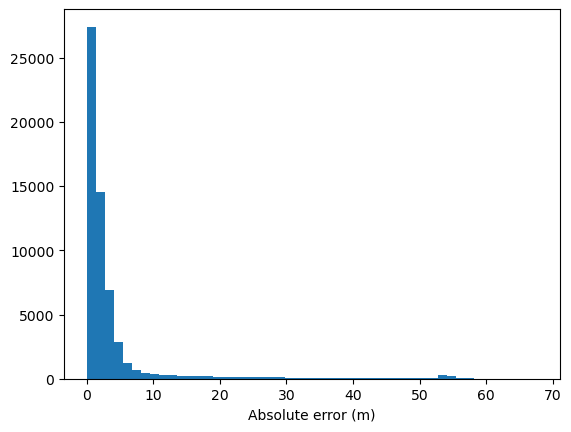

In [131]:
import matplotlib.pyplot as plt
plt.hist(np.abs(preds_sec - actual_sec), bins=50); plt.xlabel("Absolute error (m)")

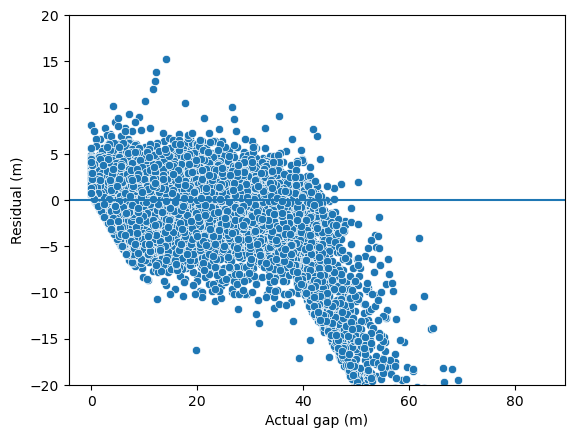

In [132]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
df_err = pd.DataFrame({
    "truth" : truth_unscaled,
    "error" : pred_unscaled - truth_unscaled
})
sns.scatterplot(x="truth", y="error", data=df_err.sample(20000))
plt.axhline(0); plt.xlabel("Actual gap (m)"); plt.ylabel("Residual (m)")
plt.ylim(-20,20)
plt.show()

# Update Horse Sectionals Table

In [133]:
final_model = model

In [134]:
import torch
from torch.utils.data import Dataset, DataLoader

class InferenceDataset(Dataset):
    def __init__(self, X, horse_ids):
        """
        X: shape (N, seq_len, input_size) -> features for each horse
        horse_ids: shape (N,) -> integer IDs or some identifier
        """
        self.X = X
        self.horse_ids = horse_ids

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return (features, horse_id)
        x_i = self.X[idx]
        h_id = self.horse_ids[idx]
        return x_i, h_id

In [135]:
# 1) Combine them:
X_all = np.concatenate([X_train_scaled, X_val_scaled, X_test_scaled], axis=0)
X_all = X_all.astype(np.float32)  
all_horse_ids = np.concatenate([horseids_train, horseids_val, horseids_test], axis=0)

inference_dataset = InferenceDataset(X_all, all_horse_ids)
inference_loader = DataLoader(inference_dataset, batch_size=128, shuffle=False)

In [137]:
import torch
import numpy as np
from pyspark.sql import Row

# We'll assume final_model(...) => (raw_score, embed_vec)
# raw_score: shape (batch,), embed_vec: shape (batch, 8)
final_model.eval()

projected_scores = {}   # {horse_id: raw_score}
projected_embeds = {}   # {horse_id: embedding array}

with torch.no_grad():
    for X_batch, ids_batch in inference_loader:
        X_batch = X_batch.to(device)            # shape (batch_size, seq_len, input_size)
        raw_scores, embed_vecs = final_model(X_batch)  
        # raw_scores => (batch_size,)
        # embed_vecs => (batch_size, embed_size)

        # Move them back to CPU + NumPy
        raw_scores_np = raw_scores.cpu().numpy()     # shape (batch_size,)
        embed_vecs_np = embed_vecs.cpu().numpy()     # shape (batch_size, embed_size)

        # For each item in the batch, store in the dictionaries
        for i in range(len(ids_batch)):
            horse_id = int(ids_batch[i])  # cast to int if needed
            projected_scores[horse_id] = float(raw_scores_np[i])
            projected_embeds[horse_id]   = embed_vecs_np[i]  # e.g. shape (embed_size,)
            
# 2) Min–max scale the raw scores to [0..1000]
scores_array = np.array(list(projected_scores.values()))
min_s = scores_array.min()
max_s = scores_array.max()
range_s = max_s - min_s if max_s > min_s else 1e-9

scaled_scores = {}
for horse_id, raw_score in projected_scores.items():
    normalized = (raw_score - min_s) / range_s   # [0..1]
    scaled_val = normalized * 1000.0            # [0..1000]
    scaled_scores[horse_id] = scaled_val

# 3) Build a Spark DataFrame with columns:
#  [horse_id, score, dim1, dim2, ..., dim8]

rows = []
for horse_id, sc in scaled_scores.items():
    emb = projected_embeds[horse_id]
    row_dict = {
        "horse_id": horse_id,
        "score": float(sc)
    }
    # Suppose embed size is 8 (like your example)
    for i, val in enumerate(emb):
        row_dict[f"dim{i+1}"] = float(val)

    rows.append(Row(**row_dict))

df_scores = spark.createDataFrame(rows)

# 4) Write to DB via Spark JDBC
staging_table = "horse_sectionals_lstm"

(
    df_scores.write
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", staging_table)
    .option("user", jdbc_properties["user"])
    .option("driver", jdbc_properties["driver"])
    .mode("overwrite")  # or "append"
    .save()
)

# Sectionals Disribution of Scores

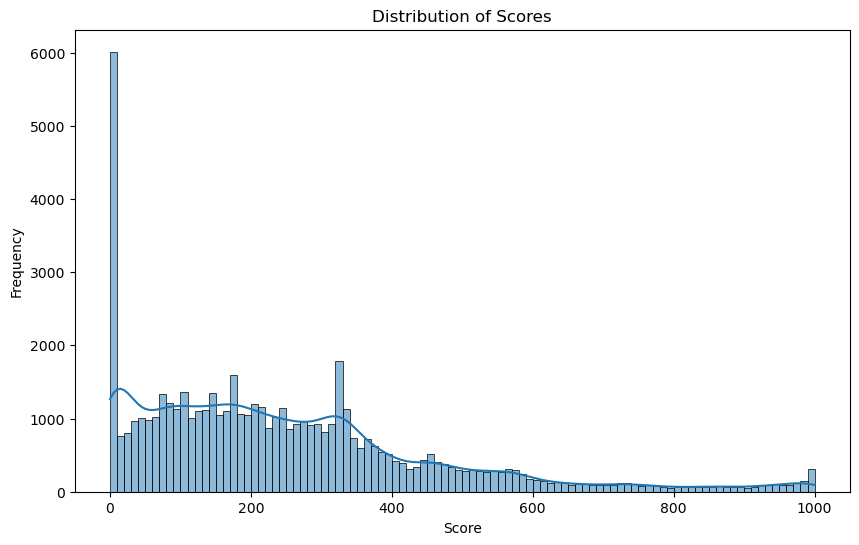

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_scores is your Spark DataFrame
df_scores_pandas = df_scores.select("score").toPandas()

# Plot the distribution of scores with more bins
plt.figure(figsize=(10, 6))
sns.histplot(df_scores_pandas["score"], bins=100, kde=True)  # Increase the number of bins to 100
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Save Model

In [139]:
torch.save(final_model.state_dict(), "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250506.pt")

# Load Model

In [140]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

{'dropout': 0.7130035200473046, 'hidden_size': 128, 'lr': 0.0038290447243701765, 'lr_gamma': 0.40483617741908506, 'lr_step': 8, 'num_layers': 3}


In [141]:
model = HorseTimeSeriesLSTM(
    input_size=6,
    hidden_size=128,
    embedding_size=16,      # ← whatever you used at training time
    num_layers=3,
    dropout=0.7130035200473046
)

state = torch.load(
    "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250506.pt",
    map_location=device            # ✦ good practice → CPU ↔ GPU agnostic
)

# strip the DataParallel prefix if you saved the wrapped model
if next(iter(state)).startswith("module."):
    state = {k.replace("module.", ""): v for k, v in state.items()}

model.load_state_dict(state)
model.to(device).eval();

/tmp/ipykernel_3192651/563716097.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(


alter table horse_scores_lstm_gps
add CONSTRAINT horse_gps_lstm_id_key UNIQUE (horse_id);

CREATE INDEX idx_horse_gps_lstm ON public.horse_scores_lstm_gps USING btree (horse_id);


### MSE or MAE on Unscaled Values, e.g.m “actual seconds"

In [142]:
# Suppose you have your trained model and your scaler_y from training:

# 1) Get predicted values on the test set (scaled):
scaled_preds = []
scaled_truth = []

for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    # forward pass
    pred_batch, _ = model(X_batch)
    # Move back to numpy
    pred_batch_np = pred_batch.cpu().detach().numpy()
    scaled_preds.append(pred_batch_np)
    scaled_truth.append(y_batch.numpy())

scaled_preds = np.concatenate(scaled_preds, axis=0)
scaled_truth = np.concatenate(scaled_truth, axis=0)

# 2) Invert the transform (assuming a MinMaxScaler or StandardScaler)
unscaled_preds = scaler_y.inverse_transform(scaled_preds.reshape(-1, 1)).flatten()
unscaled_truth = scaler_y.inverse_transform(scaled_truth.reshape(-1, 1)).flatten()

# 3) Compute MSE/MAE in real units:
mse_unscaled = np.mean((unscaled_preds - unscaled_truth)**2)
mae_unscaled = np.mean(np.abs(unscaled_preds - unscaled_truth))

print("MSE in real (seconds) domain:", mse_unscaled)
print("MAE in real (seconds) domain:", mae_unscaled)

MSE in real (seconds) domain: 81.09595
MAE in real (seconds) domain: 3.8148825


In [143]:
import numpy as np
import torch

def evaluate_unscaled(model, test_loader, device, scaler_y):
    """
    1) Make predictions in the scaled domain over *all* batches.
    2) Inverse-transform the *entire* arrays back to real units.
    3) Compute & print MSE, RMSE, MAE in the real domain.
    """
    model.eval().to(device)
    all_preds_scaled  = []
    all_labels_scaled = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            Xb = X_batch.to(device)
            pred_scaled_t, _ = model(Xb)                # (batch_size,)
            all_preds_scaled.append(pred_scaled_t.cpu().numpy())
            all_labels_scaled.append(y_batch.numpy())

    # Concatenate across all batches
    all_preds_scaled  = np.concatenate(all_preds_scaled, axis=0)   # (N_test,)
    all_labels_scaled = np.concatenate(all_labels_scaled, axis=0)  # (N_test,)

    # Inverse-transform the *full* arrays
    pred_unscaled  = scaler_y.inverse_transform(
                        all_preds_scaled.reshape(-1,1)
                     ).ravel()
    label_unscaled = scaler_y.inverse_transform(
                        all_labels_scaled.reshape(-1,1)
                     ).ravel()

    # Compute real-domain metrics
    mse  = np.mean((pred_unscaled - label_unscaled)**2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(pred_unscaled - label_unscaled))

    print(f"Test set → MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    return rmse, mae, pred_unscaled, label_unscaled, all_preds_scaled

# Call it like this:
rmse, mae, preds_sec, actual_sec, scaled_preds = evaluate_unscaled(
    final_model, test_loader, device, scaler_y
)

print(f"Final RMSE in real domain: {rmse:.3f}")
print(f"Final MAE  in real domain: {mae:.3f}")

Test set → MSE=81.0959, RMSE=9.0053, MAE=3.8149
Final RMSE in real domain: 9.005
Final MAE  in real domain: 3.815


In [144]:
rmse, mae, preds_sec, actual_sec, pred_scaled = evaluate_unscaled(final_model, test_loader, device, scaler_y)

print(f"RMSE in real domain: {rmse:.3f}")
print(f"MAE  in real domain: {mae:.3f}")

Test set → MSE=81.0959, RMSE=9.0053, MAE=3.8149
RMSE in real domain: 9.005
MAE  in real domain: 3.815


## Compare Baseline

In [145]:
y_train_unscaled = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_val_unscaled   = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_test_unscaled  = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_unscaled = all_pd["target"].values

In [146]:
pred_unscaled = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

In [147]:
import numpy as np

def compute_mean_baseline_metrics(y_train_unscaled, y_test_unscaled):
    """
    1) Compute the mean finishing time on the training set.
    2) Create baseline predictions => the same mean time for every test row.
    3) Compute MSE, RMSE, and MAE in real (seconds) domain.
    """

    # 1) Mean finishing time from training set
    train_mean_time = np.mean(y_train_unscaled)

    # 2) Baseline predictions: fill every test sample with 'train_mean_time'
    baseline_pred = np.full_like(y_test_unscaled, train_mean_time)

    # 3) Metrics
    mse  = np.mean((baseline_pred - y_test_unscaled)**2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(baseline_pred - y_test_unscaled))

    print(f"[Mean Baseline]")
    print(f"  Train mean time = {train_mean_time:.3f} seconds")
    print(f"  Test MSE  = {mse:.3f}")
    print(f"  Test RMSE = {rmse:.3f}")
    print(f"  Test MAE  = {mae:.3f}")

    return mse, rmse, mae

# EXAMPLE USAGE (assuming you already have unscaled arrays):
# y_train_unscaled = ...
# y_test_unscaled  = ...
# compute_mean_baseline_metrics(y_train_unscaled, y_test_unscaled)

In [148]:
# FIRST: invert them to get unscaled times:
y_train_unscaled = scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).ravel()
y_test_unscaled  = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

# THEN: call the baseline function:
compute_mean_baseline_metrics(y_train_unscaled, y_test_unscaled)

[Mean Baseline]
  Train mean time = 18.944 seconds
  Test MSE  = 286.962
  Test RMSE = 16.940
  Test MAE  = 13.069


(286.9624065982517, 16.939964775590642, 13.069065797562198)